In [4]:
# Import important libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from efficientnet_pytorch import EfficientNet
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy
from torchvision import models, transforms, datasets
import pywt
import pywt.data
from pywt import dwt2, idwt2

In [3]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=84b1e2d90b795ced36b21845354403a731eed9f9e0ad0d88f69052bcadb2fe67
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [6]:
# Plots
TRAINING_LOSS = []
VALIDATION_LOSS = []
VALIDATION_ACCURACY = []
LEARNING_RATE = []

f = open("/kaggle/working/Log.txt", 'a')
f.truncate(0)
f.write("\n\n\n\n\n")

# If GPU is available then use GPU else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import numpy as np

class AugmentedSubset(torch.utils.data.Dataset):
    def __init__(self, dataset, classes_to_augment, augmentation_transform):
        self.dataset = dataset
        self.classes_to_augment = classes_to_augment
        self.augmentation_transform = augmentation_transform
    def __getitem__(self, index):
        image, label = self.dataset[index]
        # Check if the label corresponds to a class to augment
        if label in self.classes_to_augment:
            # Apply augmentation
            image = self.augmentation_transform(image)
        return image, label
    def __len__(self):
        return len(self.dataset)
# Define transforms for training and validation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomVerticalFlip()  # Convert to tensor
])

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a fixed size
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

data_dir = "/kaggle/input/final-compressed-dss/Final_patches"  # Change this to your data directory
data = datasets.ImageFolder(root=data_dir , transform=data_transforms)
train_size = int(0.7 * len(data))  # 70% for training
val_size = int(0.15 * len(data))   # 15% for validation
test_size = len(data) - train_size - val_size  # Remaining for testing

original_train_data, val_dataset, test_dataset = random_split(data, [train_size, val_size, test_size])
# Define classes to augment
classes_to_augment = [0,2,3]  # Example: classes 0, 1, and 2 will have augmentation

# Create augmented dataset with on-the-fly augmentation
augmented_train_data = AugmentedSubset(original_train_data, classes_to_augment, train_transform)

train_loader = torch.utils.data.DataLoader(augmented_train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [7]:
# Testing loop
def test(model, test_loader, device):
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to CUDA if available
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    test_accuracy = 100 * test_correct / test_total
    print(f'Testing Accuracy: {test_accuracy:.2f}%, Epochs: {epoch}')
    f.write(f'Testing Accuracy: {test_accuracy:.2f}%, Epochs: {epoch}\n')

In [8]:
# def wav(img):
#   img_list = []
#   # for i in range(img.shape[2]):
#   cA, (cH, cV, cD) = pywt.dwt2(img, 'haar')
#   img_list.extend([cA, cH, cV, cD])
#   return img_list

def wav(img):
  # img_list = []
  # for i in range(img.shape[2]):
  cA, (cH, cV, cD) = pywt.dwt2(img, 'haar')
  # img_list.extend([cA, cH, cV, cD])
  return cA, cH, cV, cD

def extract(imgs, R):
  out_list = []

  for i in range(imgs.shape[0]):
    img = imgs[i,:,:,:]
    prev_img = 0.2989 * img[0,:,:] + 0.5870 * img[1,:,:] + 0.1140 * img[2,:,:]
    # prev_img = prev_img.reshape((prev_img.shape[0], prev_img.shape[1], 1)).cpu()
    prev_img = prev_img.cpu()
    # print(prev_img.shape)
    
    for j in range(R):
        # print(f'orig img {prev_img}')
        trans_img= wav(prev_img)
        # print('hey')
        # print(trans_img[0].shape, len(trans_img))
        out = cv2.merge(trans_img)
        prev_img = out[:,:,0].copy()
    out_list.append(out[:,:,:4].flatten())
    
  return np.stack(out_list)

In [8]:
# class WaveNet(nn.Module):
#   def __init__(self, efficient_net, wavelet_in_fectures, R = 3):
#     super().__init__()
#     self.R = R
#     self.efficient_net = efficient_net
#     self.eff_in_features = efficient_net._fc.in_features
#     self.efficient_net._fc = nn.Identity()
#     self.wavelet_in_features = wavelet_in_fectures
#     self.out_features = num_classes
#     self.lin1=nn.Linear(in_features=self.wavelet_in_features,out_features=self.wavelet_in_features/3)
#     self.lin1=nn.Linear(in_features=self.wavelet_in_features/3,out_features=self.wavelet_in_features/9)
#     print(f"Efficient-net features:{self.eff_in_features}, Wavelet features:{self.wavelet_in_features/9}")
#     self.final_layer = nn.Linear(in_features=self.wavelet_in_features/9+self.eff_in_features, out_features=self.out_features)
#     # self.wav_block = 

#   def forward(self, inputs):
#     pre_final_eff = self.efficient_net(inputs).to(device)
#     wav = extract(inputs, self.R)
#     wav = torch.from_numpy(wav).to(device)
#     wav1 = self.lin1(wav)
#     wav2=self.lin2(wav1)
#     final_ip_feat = torch.cat((pre_final_eff, wav2), axis=1)
#     #final_ip_feat = pre_final_eff
#     output = self.final_layer(final_ip_feat)
#     return output

In [9]:
import torch
import torch.nn as nn

class WaveNet(nn.Module):
    def __init__(self, efficient_net, wavelet_in_features, num_classes, R=3):
        super().__init__()
        self.R = R
        self.efficient_net = efficient_net
        self.eff_in_features = efficient_net._fc.in_features
        self.efficient_net._fc = nn.Identity()
        self.wavelet_in_features = wavelet_in_features
        self.out_features = num_classes
        self.lin1 = nn.Linear(in_features=self.wavelet_in_features, out_features=self.wavelet_in_features // 3)
        print(f"Efficient-net features: {self.eff_in_features}, Wavelet features: {self.wavelet_in_features // 3}")
        self.final_layer = nn.Linear(in_features=self.wavelet_in_features // 3 + self.eff_in_features, out_features=self.out_features)

    def forward(self, inputs):
        pre_final_eff = self.efficient_net(inputs)
        wav = extract(inputs, self.R)  # Assuming extract is defined elsewhere
        wav = torch.from_numpy(wav).to(inputs.device)  # Assuming inputs.device gives the correct device
        wav1 = self.lin1(wav)
        final_ip_feat = torch.cat((pre_final_eff, wav1), dim=1)
        output = self.final_layer(final_ip_feat)
        return output


In [10]:
import cv2
im=cv2.imread('/kaggle/input/final-compressed-dss/Final_patches/0patches/patch_101_3_7_0.png')
print(im.shape)

(550, 380, 3)


In [16]:
model = EfficientNet.from_pretrained('efficientnet-b0')

net = WaveNet(model, wavelet_in_features,5,R=4).to(device)
print(summary(net))

Loaded pretrained weights for efficientnet-b0
Efficient-net features: 1280, Wavelet features: 261
Layer (type:depth-idx)                                  Param #
WaveNet                                                 --
├─EfficientNet: 1-1                                     --
│    └─Conv2dStaticSamePadding: 2-1                     864
│    │    └─ZeroPad2d: 3-1                              --
│    └─BatchNorm2d: 2-2                                 64
│    └─ModuleList: 2-3                                  --
│    │    └─MBConvBlock: 3-2                            1,448
│    │    └─MBConvBlock: 3-3                            6,004
│    │    └─MBConvBlock: 3-4                            10,710
│    │    └─MBConvBlock: 3-5                            15,350
│    │    └─MBConvBlock: 3-6                            31,290
│    │    └─MBConvBlock: 3-7                            37,130
│    │    └─MBConvBlock: 3-8                            102,900
│    │    └─MBConvBlock: 3-9               

In [17]:
compression_degree = 4
L = 550 #(224)
W = 380 #(224)
l=28
w=28
early_stopping = 40
BATCH_SIZE = 64
wavelet_in_features = 784#l*w*4
num_classes = 5
EPOCHS = 150
LOG_PATH = "/kaggle/working/Log.txt"
SAVE_PATH = '/kaggle/working/'
from torchinfo import summary
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=1,gamma=0.9)

print_every = 20
total_batches = len(train_loader)
max_val_accuracy = 0
stop_count = 0
running_loss = 0.0
epoch_loss = 0.0
val_loss = 0.0
num_epochs = EPOCHS
print(f"Number of batches: {total_batches}")
import cv2
early_stopping=5

Number of batches: 61


In [18]:
f = open("/kaggle/working/Log.txt", 'a')

TRAINING_LOSS = []
VALIDATION_LOSS = []
VALIDATION_ACCURACY = []
LEARNING_RATE = []

f = open(LOG_PATH, 'a')

for epoch in range(num_epochs):
    # Training loop
    if(stop_count > early_stopping or epoch == num_epochs):
        break

    net.train()
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        #print(inputs.shape)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if (batch_idx + 1) % print_every == 0 or (batch_idx + 1) == total_batches:
            avg_loss = running_loss / print_every
            print(f'Training Epoch - [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{total_batches}], Loss: {avg_loss:.4f}')
            f.write(f'Training Epoch - [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{total_batches}], Loss: {avg_loss:.4f}\n')
            epoch_loss += running_loss
            running_loss = 0
    epoch_loss = epoch_loss / len(train_loader)
    TRAINING_LOSS.append(epoch_loss)

    print(f'Epoch Loss: {epoch_loss:.4f}')
    # f.write(f'Epoch Loss: {epoch_loss:.4f}\n')

    epoch_loss = 0

    # Validation loop
    net.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to CUDA if available
            # print(inputs.shape)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_loss/len(val_loader)
    VALIDATION_LOSS.append(val_loss)

    val_accuracy = 100 * val_correct / val_total
    VALIDATION_ACCURACY.append(val_accuracy)

    LEARNING_RATE.append(optimizer.param_groups[-1]['lr'])

    # Stoping criteria
    if(val_accuracy > max_val_accuracy):
        max_val_accuracy = val_accuracy
        torch.save(net.state_dict(), f'{SAVE_PATH}epoch{epoch+1}.pth')
        stop_count = 0
    else:
        stop_count += 1

    scheduler.step()

    print(f'Validation - Epoch [{epoch+1}/{num_epochs}], Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')
    f.write(f'Validation - Epoch [{epoch+1}/{num_epochs}], Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%\n')
    print(f"\nstop_count: {stop_count}")
f.close()



Training Epoch - [1/150], Batch [20/61], Loss: 3.6908
Training Epoch - [1/150], Batch [40/61], Loss: 1.3098
Training Epoch - [1/150], Batch [60/61], Loss: 0.7957
Training Epoch - [1/150], Batch [61/61], Loss: 0.0450
Epoch Loss: 1.9151
Validation - Epoch [1/150], Loss: 1.1810, Accuracy: 66.27%

stop_count: 0
Training Epoch - [2/150], Batch [20/61], Loss: 0.6709
Training Epoch - [2/150], Batch [40/61], Loss: 0.6475
Training Epoch - [2/150], Batch [60/61], Loss: 0.7109
Training Epoch - [2/150], Batch [61/61], Loss: 0.0271
Epoch Loss: 0.6742
Validation - Epoch [2/150], Loss: 1.4964, Accuracy: 59.76%

stop_count: 1
Training Epoch - [3/150], Batch [20/61], Loss: 0.5008
Training Epoch - [3/150], Batch [40/61], Loss: 0.4490
Training Epoch - [3/150], Batch [60/61], Loss: 0.5946
Training Epoch - [3/150], Batch [61/61], Loss: 0.0308
Epoch Loss: 0.5165
Validation - Epoch [3/150], Loss: 1.2196, Accuracy: 60.84%

stop_count: 2
Training Epoch - [4/150], Batch [20/61], Loss: 0.4441
Training Epoch - [4

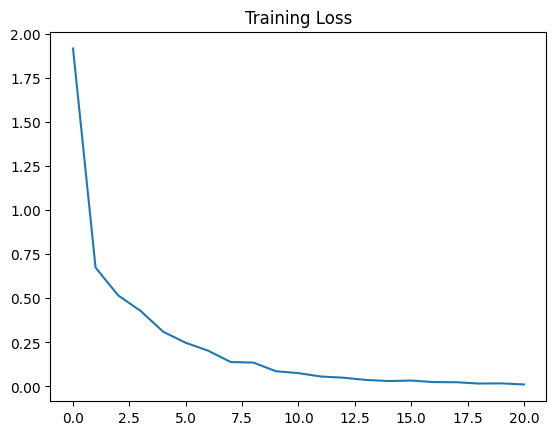

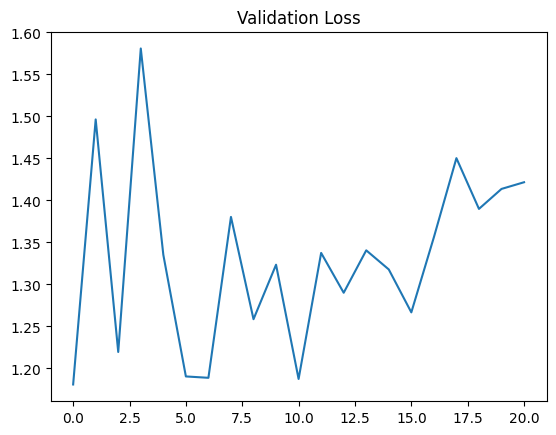

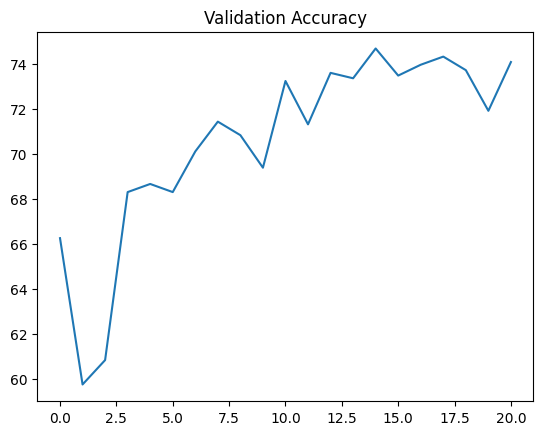

In [20]:
import matplotlib.pyplot as plt
plt.plot([epoch for epoch in range(21)], TRAINING_LOSS)
plt.title('Training Loss')
plt.show()
plt.plot([epoch for epoch in range(21)], VALIDATION_LOSS)
plt.title('Validation Loss')
plt.show()
plt.plot([epoch for epoch in range(21)], VALIDATION_ACCURACY)
plt.title('Validation Accuracy')
plt.show()

In [23]:
f = open('/kaggle/working/Log.txt', 'a')
PATH = '/kaggle/working/epoch15.pth'
model = EfficientNet.from_pretrained('efficientnet-b0')
best_model = WaveNet(model, wavelet_in_features, 5,R=4).to(device) 
best_model.load_state_dict(torch.load(PATH))
best_model.to(device)
test(best_model, test_loader, device)
f.close()

Loaded pretrained weights for efficientnet-b0
Efficient-net features: 1280, Wavelet features: 261
Testing Accuracy: 75.96%, Epochs: 21


In [24]:
def test(model, test_loader, device):
    model.eval()
    class_correct = [0 for _ in range(5)]
    class_total = [0 for _ in range(5)]
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to CUDA if available
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            for i in range(5):  # Iterate over each class
                class_total[i] += (labels == i).sum().item()
                class_correct[i] += ((predicted == labels) & (labels == i)).sum().item()
    for i in range(5):  # Calculate accuracy for each class
        class_accuracy = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f'Class {i} Accuracy: {class_accuracy:.2f}%')


In [26]:
f = open('/kaggle/working/Log.txt', 'a')
PATH = '/kaggle/working/epoch15.pth'
model = EfficientNet.from_pretrained('efficientnet-b0')
best_model = WaveNet(model, wavelet_in_features, 5,R=4).to(device) 
best_model.load_state_dict(torch.load(PATH))
best_model.to(device)
test(best_model, test_loader, device)
f.close()

Loaded pretrained weights for efficientnet-b0
Efficient-net features: 1280, Wavelet features: 261
Class 0 Accuracy: 89.87%
Class 1 Accuracy: 78.18%
Class 2 Accuracy: 31.82%
Class 3 Accuracy: 30.34%
Class 4 Accuracy: 86.22%
